# Evaluation Notebook: BiMPM with Frozen RoBERTa Embeddings (Solution B)

This notebook is designed to evaluate the performance of the **BiMPM-style model with frozen RoBERTa embeddings**

---
**Notebook overview:**
1. **Loads** the development dataset (`dev.csv`)
2. **Generates embeddings** using the frozen `roberta-base` model
3. **Loads the trained BiMPM model** (`best_bimpm_model.keras`)
4. **Makes predictions** on the dev set
5. **Evaluates model performance** using:
   - Accuracy
   - Precision, Recall, F1
   - Confusion Matrix
6. **Compares against a random baseline**
7. **Saves predictions** to a CSV file

---

> Note:
This notebook includes all custom components needed to run the model — including the BiMPMMatching layer and the split_premise_and_hypothesis function.
As long as the trained model file best_bimpm_model.keras is in the same directory, this notebook will work out of the box.

Setup and Install Packages

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, TFAutoModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re, string, os
from tensorflow.keras.layers import Layer
from keras.saving import register_keras_serializable
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score
from sklearn.metrics import roc_curve, auc
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.metrics import roc_curve, auc


# dev_path   = "/content/drive/MyDrive/dataset/training_data/NLI/dev.csv"
# train_path = "/content/drive/MyDrive/dataset/training_data/NLI/train.csv"
# model_path = "/content/drive/MyDrive/dataset/training_data/NLI/best_bimpm_model.keras"
# dev_predictions = "/content/drive/MyDrive/dataset/training_data/NLI/dev_predictions.csv"

model_path = "savedModels/best_bimpm_model.keras"
train_path = "../Data/train.csv"
dev_path = "../Data/dev.csv"
dev_predictions = "savedModels/dev_predictions.csv"

MODEL_NAME  = "roberta-base"
MAX_LEN = 50
VOCAB_SIZE = 10000


Mounted at /content/drive


### Load and Preprocess

In [66]:
def clean_text(text):
    text = ''.join(ch for ch in text if ch not in string.punctuation)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_and_preprocess_data(train_path,dev_path):
    train_df = pd.read_csv(train_path)
    dev_df   = pd.read_csv(dev_path)

    for df in (train_df, dev_df):
        df['premise'] = df['premise'].fillna("").apply(clean_text)
        df['hypothesis'] = df['hypothesis'].fillna("").apply(clean_text)

    train_labels = train_df.label.values.astype("int32")
    dev_labels   = dev_df.label.values.astype("int32")

    return train_df, dev_df, train_labels, dev_labels

train_df, dev_df, train_labels, dev_labels = load_and_preprocess_data(train_path,dev_path)

Extract RoBERTa Embeddings

In [67]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
transformer = TFAutoModel.from_pretrained(MODEL_NAME)
transformer.trainable = False

def encode(df, max_len=50):
    return tokenizer(
        df['premise'].tolist(),
        df['hypothesis'].tolist(),
        padding="max_length", truncation=True, max_length=max_len,
        return_tensors="tf"
    )

def compute_embeddings(input_ids, attention_mask, batch_size=256):
    embeddings = []
    dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_mask)).batch(batch_size)
    for batch_ids, batch_mask in dataset:
        output = transformer(batch_ids, attention_mask=batch_mask).last_hidden_state
        embeddings.append(output.numpy())
    return np.vstack(embeddings)


dev_encodings = encode(dev_df)
dev_embeddings   = compute_embeddings(dev_encodings['input_ids'], dev_encodings['attention_mask'])

train_encoding = encode(train_df)
train_embeddings = compute_embeddings(train_encoding['input_ids'], train_encoding['attention_mask'])


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.embeddings.position_ids', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

### Custom BiMPM Matching Layer

> Note:
This function is used inside a Lambda layer in the model architecture to split the inputs into premise and hypothesis embeddings.
Because the model was saved with this custom function, we need to **redefine it exactly as it was during training** so that Keras can correctly rebuild the model when loading it.


In [68]:
class BiMPMMatching(Layer):
    def __init__(self, hidden_size, num_perspectives, **kwargs):
        super().__init__(**kwargs)
        self.hidden_size = hidden_size
        self.num_perspectives = num_perspectives
        self.W = self.add_weight(
            shape=(num_perspectives, hidden_size * 2),
            initializer="random_normal",
            trainable=True,
            name="W_bimpm"
        )

    def call(self, inputs):
        u, v = inputs

        def cosine_similarity(tensor_a, tensor_b):
            a_expanded = tf.expand_dims(tensor_a, axis=2) * tf.reshape(self.W, (1, 1, self.num_perspectives, self.hidden_size * 2))
            b_expanded = tf.expand_dims(tensor_b, axis=2) * tf.reshape(self.W, (1, 1, self.num_perspectives, self.hidden_size * 2))
            return -tf.keras.losses.cosine_similarity(a_expanded, b_expanded, axis=-1)

        def full_match(sequence, last_step_other_sequence):
            last_step_other_sequence_expanded = tf.repeat(tf.expand_dims(last_step_other_sequence, 1), tf.shape(sequence)[1], axis=1)
            return cosine_similarity(sequence, last_step_other_sequence_expanded)

        def maxpool_match(sequence_a, sequence_b):
            pooled_similarities = []
            for i in range(sequence_a.shape[1]):
                sequence_a_i = tf.repeat(tf.expand_dims(sequence_a[:, i, :], 1), sequence_b.shape[1], axis=1)
                similarity_scores = cosine_similarity(sequence_a_i, sequence_b)
                pooled_similarities.append(tf.reduce_max(similarity_scores, axis=1))
            return tf.stack(pooled_similarities, axis=1)

        full_match_premise = full_match(u, v[:, -1, :])
        full_match_hypothesis = full_match(v, u[:, -1, :])
        maxpool_premise = maxpool_match(u, v)
        maxpool_hypothesis = maxpool_match(v, u)

        return tf.concat([full_match_premise, full_match_hypothesis, maxpool_premise, maxpool_hypothesis], axis=-1)

@register_keras_serializable()
def split_premise_and_hypothesis(x):
    return tf.split(x, num_or_size_splits=2, axis=1)


### Load trained BiMPM model

In [69]:
if not os.path.exists(model_path):
    raise FileNotFoundError(
        "Model file 'best_bimpm_model.keras' not found.\n"
        "Please make sure you have trained the model first and saved it to this path."
    )

model = tf.keras.models.load_model(model_path, custom_objects={"BiMPMMatching": BiMPMMatching,'split_premise_and_hypothesis': split_premise_and_hypothesis})

### Predict on Dev set

In [70]:
bimpm_preds= model.predict(dev_embeddings).argmax(axis=1)


211/211 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step


### Evaluation Metrics

In [101]:
accuracy_score(y_true=dev_labels, y_pred=bimpm_preds)

print("\nClassification Report:")
print(classification_report(dev_labels, bimpm_preds, digits=4))

acc = accuracy_score(dev_labels, bimpm_preds)
prec, rec, f1, _ = precision_recall_fscore_support(dev_labels, bimpm_preds, average="macro")
auc = roc_auc_score(dev_labels, bimpm_preds)

print(f"\nAccuracy: {acc*100:.2f}%")
print(f"Macro F1: {f1:.4f}")
print(f"Macro Precision: {prec:.4f}")
print(f"Macro Recall: {rec:.4f}")
print(f"AUC: {auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0     0.7466    0.7397    0.7431      3258
           1     0.7583    0.7648    0.7615      3478

    accuracy                         0.7527      6736
   macro avg     0.7524    0.7523    0.7523      6736
weighted avg     0.7526    0.7527    0.7526      6736


Accuracy: 75.27%
Macro F1: 0.7523
Macro Precision: 0.7524
Macro Recall: 0.7523
AUC: 0.7523


### Confusion Matrix

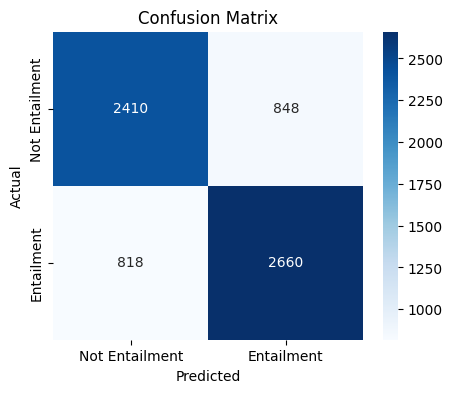

In [72]:
cm = confusion_matrix(dev_labels, bimpm_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Entailment", "Entailment"], yticklabels=["Not Entailment", "Entailment"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Visual Comparison of Precision, Recall, and F1 for Each

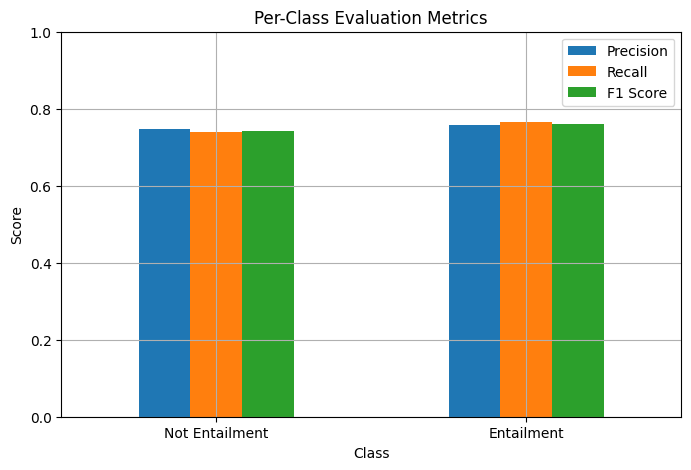

In [73]:
prec, rec, f1, _ = precision_recall_fscore_support(dev_labels, bimpm_preds, zero_division=0)

metrics_df = pd.DataFrame({
    "Class": ["Not Entailment", "Entailment"],
    "Precision": prec,
    "Recall": rec,
    "F1 Score": f1
})

metrics_df.set_index("Class").plot(kind="bar", figsize=(8, 5))
plt.title("Per-Class Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

### Example Misclassifications

In [75]:
misclassified_examples = dev_df[bimpm_preds != dev_labels].copy()
misclassified_examples["true"] = dev_labels[bimpm_preds != dev_labels]
misclassified_examples["pred"] = bimpm_preds[bimpm_preds != dev_labels]
misclassified_examples[["premise", "hypothesis", "true", "pred"]].sample(5)

,premise,hypothesis,true,pred
2324,Several security managers said that by partici...,The security managers in the study joined in o...,0,1
4868,The Iron Jaw and Adrins Return,Adrin dragged The Iron Jaw back with him,1,0
955,The port is virtually round the corner from th...,It takes at least two days to go from the port...,0,1
727,As he wandered about viewing cactus syrup swee...,Drew constantly forgot the color of his country,1,0
4521,Some of the last of the Trotskyites have been ...,We are in danger because of the Trotskyites on...,0,1


from matplotlib import pyplot as plt
_df_12['true'].plot(kind='hist', bins=20, title='true')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['pred'].plot(kind='hist', bins=20, title='pred')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_14.groupby('premise').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_15.groupby('hypothesis').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16.plot(kind='scatter', x='true', y='pred', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17['true'].plot(kind='line', figsize=(8, 4), title='true')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['pred'].plot(kind='line', figsize=(8, 4), title='pred')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['hypothesis'].value_counts()
    for x_label, grp in _df_19.groupby('premise')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('premise')
_ = plt.ylabel('hypothesis')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['premise'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='true', y='premise', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['hypothesis'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='true', y='hypothesis', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['premise'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='pred', y='premise', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_23['hypothesis'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_23, x='pred', y='hypothesis', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

### Save Dev Predictions

In [76]:
pd.DataFrame({"prediction": bimpm_preds}).to_csv(dev_predictions, index=False)

print("Saved predictions to:", dev_predictions)

Saved predictions to: /content/drive/MyDrive/dataset/training_data/NLI/dev_predictions.csv


### Comparision with Baseline LSTM Model

,Metric,LSTM Baseline,BiMPM + Frozen RoBERTa
0,Accuracy,66.1,75.3
1,Macro Precision,66.0,75.2
2,Macro Recall,66.0,75.2
3,Macro F1,66.0,75.2


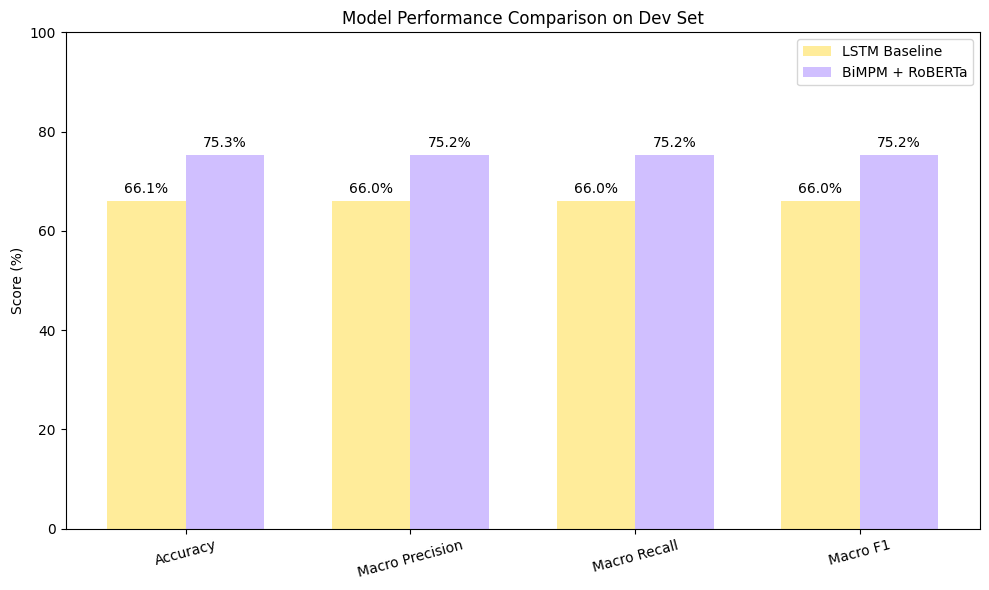

In [8]:
def compute_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    return [
        round(accuracy, 1),
        round(precision * 100, 1),
        round(recall * 100, 1),
        round(f1 * 100, 1)
    ]

# These values were derived from the Codabench LSTM Baseline
lstm_metrics = [66.1, 66.0, 66.0, 66.0]

bimpm_df = pd.read_csv(dev_predictions)
bimpm_preds = bimpm_df["prediction"].values

dev_labels = pd.read_csv(dev_path)["label"].values

bimpm_metrics = compute_metrics(dev_labels, bimpm_preds)

metric_names = ["Accuracy", "Macro Precision", "Macro Recall", "Macro F1"]
comparison_df = pd.DataFrame({
    "Metric": metric_names,
    "LSTM Baseline": lstm_metrics,
    "BiMPM + Frozen RoBERTa": bimpm_metrics
})

display(comparison_df)

x = np.arange(len(metric_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, lstm_metrics, width, label='LSTM Baseline', color='#FFEC9A')
bars2 = ax.bar(x + width/2, bimpm_metrics, width, label='BiMPM + RoBERTa', color='#D0BFFF')

ax.set_ylabel("Score (%)")
ax.set_title("Model Performance Comparison on Dev Set")
ax.set_xticks(x)
ax.set_xticklabels(metric_names, rotation=15)
ax.set_ylim(0, 100)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{bar.get_height():.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()